In [1]:
from CIR import get_CIR
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

We model Overnight Indexed Swaps (OISs) on a stochastic overnight interest rate $\{r_t\}_{t\in[0,T]}$ with the CIR process dynamics:

$$\begin{cases} dr(t) = \alpha \left( b-r(t)\right) + \sigma \sqrt{r(t)}dW_t\\
r(0)\in\mathbb{R}^+ \end{cases}$$

I simulate 3 years of observation. Every night I assume there are 100 points of the process of which I am interested 
only in the last one:

In [2]:
TotPoints = 3 * 365

#simulation time grid
ts = np.linspace(0., 1., TotPoints)

#CIR process parameters
alpha = 5
b = 0.5
sigma = 1.
v_0 = 1

In [3]:
#Simulate CIR process
process = get_CIR(ts, alpha, b, sigma, v_0, n_samples=3)

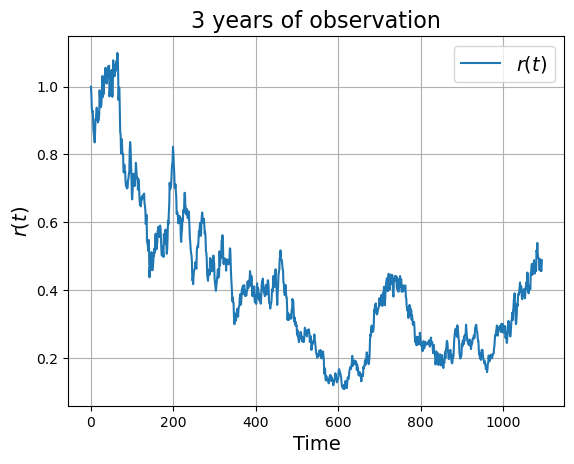

In [4]:
# Plot trajectories
plt.plot(process[0], label='$r(t)$')
plt.grid(True)
plt.legend(fontsize=14)
plt.title('3 years of observation', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('$r(t)$', fontsize=14)
plt.show()

Let's define the formula for the affine term structure coming from [McNeil et al. 2015]. by denoting $\gamma = \sqrt{\alpha^2 + 2\sigma^2}$, we get:

$$p(t,T) = \mathbb{E}^\mathbb{Q}\left[ \exp{\left( -\int_t^T{r(s)ds} \right)} \right] = \exp{\left( A(T-t) + B(T-t)\cdot r(t) \right)}$$

with:

$$A(\tau) = \frac{2\alpha b }{\sigma^2}\ln{\left( \frac{2\gamma e^{\tau(\gamma + \alpha)/2} }{\gamma - \alpha + e^{\gamma\tau}(\gamma+\alpha)} \right)} = C * \ln{\left(\frac{D}{E}\right)}$$

$$B(\tau) = \frac{2(1-e^{\gamma\tau})}{\gamma-\alpha+e^{\gamma\tau}(\gamma+\alpha)} = \frac{F}{E}$$

In [5]:
def get_zero_bond_price(alpha, b, sigma, process, t, T):
    """
    For the moment we assume a fixed contract length of one year
    """

    tau = (T-t) / 365
    gamma = np.sqrt( (alpha ** 2) + 2 * (sigma ** 2))
    C =  2 * alpha * b  / (sigma ** 2)
    D =  2 * gamma * np.exp( tau * ( gamma + alpha ) / 2 )
    E = gamma - alpha + np.exp( gamma * tau ) * (gamma + alpha)
    F = 2 * (1 - np.exp( gamma * tau ))
    
    A = C * np.log( D / E )
    B = F / E

    r_t = process[t]
    
    return np.exp( A + B * r_t )
    

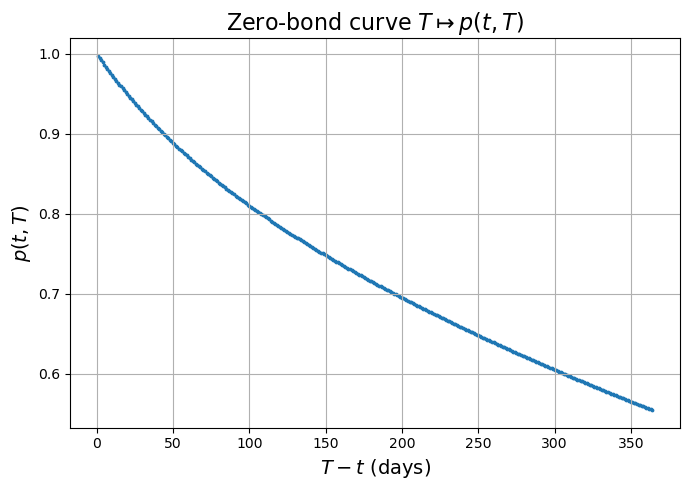

In [6]:
plt.figure(figsize=(7,5))
for i in range(1,365):
    plt.scatter(i, get_zero_bond_price(alpha, b, sigma, process=process[0], t=0, T=i),s=3, c='tab:blue')
plt.title('Zero-bond curve $T\mapsto p(t,T)$', fontsize=16)
plt.xlabel('$T-t$ (days)', fontsize=14)
plt.ylabel('$p(t,T)$', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Let's write down the function that computes the OIS swap rate that make the value of the OIS zero at the initial time, according to:

$$ K = -\frac{1}{T-t_0} \ln{p(t_0,T)} = R(t_0,T) $$

Or in discrete time we get:

$$ K = -\frac{1}{T-t_0}\frac{p(t_0, T) - 1}{p(t_0, T)}$$

In [7]:
def get_ois_swap_rate(t_0, T, alpha, b, sigma, process):

    price = get_zero_bond_price(alpha, b, sigma, process, t=t_0, T=T)
    tau = (T-t_0) / 365
    #return - 1/(tau) * np.log(price)
    return -1 / tau * ((price -1) / price)

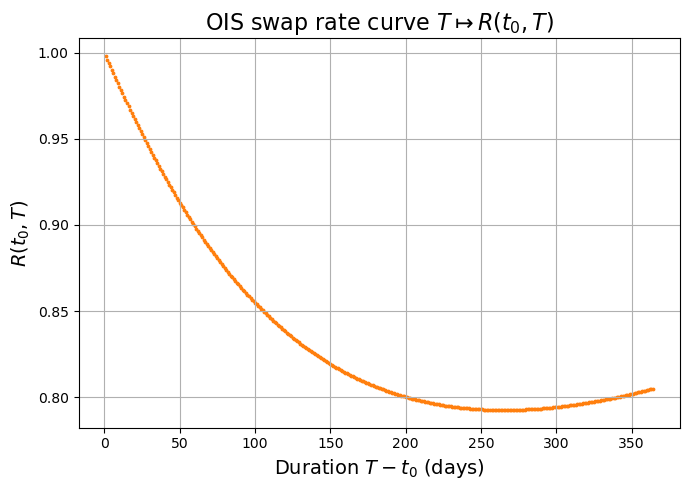

In [8]:
plt.figure(figsize=(7,5))
for i in range(1,365):
    plt.scatter(i, get_ois_swap_rate(t_0=0, T=i, alpha=alpha, b=b, sigma=sigma, process=process[0]), s=3, c='tab:orange')
plt.title('OIS swap rate curve $T\mapsto R(t_0,T)$', fontsize=16)
plt.xlabel('Duration $T-t_0$ (days)', fontsize=14)
plt.ylabel('$R(t_0,T)$', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Now we define the function that computes the mark-to-market value at time t of the OIS which is given by:

$$ V(t) = \delta^{ij}_{k}\cdot \left(V^{fixed}(t) - V^{float}(t) \right) =  \delta^{ij}_{k}\cdot N \left(e^{K(T-t_0)-R(t,T)(T-t)} - \exp{\left(\int_{t_0}^t {r(s) ds}\right)}\right)$$

where K was fixed as above and $\delta^{ij}_{k} = 1$ for RFS while $\delta^{ij}_{k} = -1$ for the PFS. Or in the discrete case (for simply compounded interest rate K) with $dt=1/365$:

$$V_k^{(ij)}(t)= \delta^{ij}_{k}\cdot N \left[ (1 + K (T-t_0)) - \prod_{i=t_0}^{t}{(1+r(t_i)dt)} - p(t,T)^{-1} \right]$$

In [9]:
def get_mark_to_market_value_continuous(delta, t_0, t, T, process, notional = 1):

    tau_0 = (T - t_0) / 365
    tau_t = (T - t) / 365

    exp1 = get_ois_swap_rate(t_0=t_0, T=T, alpha=alpha, b=b, sigma=sigma, process=proc[0]) * tau_0
    exp2 = get_ois_swap_rate(t_0=t, T=T, alpha=alpha, b=b, sigma=sigma, process=proc[0]) * tau_t

    print(f'Exp 1 {exp1}')
    print(f'Exp 2 {exp2}')

    c = np.exp(exp1 - exp2)
    d = 1
    for i in range(t_0, t):
        #print('d: ',d)
        d*= (1+(process[i]/365))
    return delta * notional * (c-d)

def get_mark_to_market_value(delta, t_0, t, T, process, notional = 1):
    
    tau_0 = (T-t_0) / 365
    term1 = (1 + get_ois_swap_rate(t_0, T, alpha, b, sigma, process) * tau_0)
    if t > t_0:
        term2 = 1
        for i in range(t_0, t):
            term2 *= (1 + (process[i]/365))
    else:
        term2 = 0
    term3 = get_zero_bond_price(alpha, b, sigma, process, t=t, T=T)
    return delta * notional * (term1 - term2 - (1 / term3))

In [10]:
get_mark_to_market_value(delta = 1, t_0 = 0, t = 150, T = 200, process = process[0])

-1.033668363105263

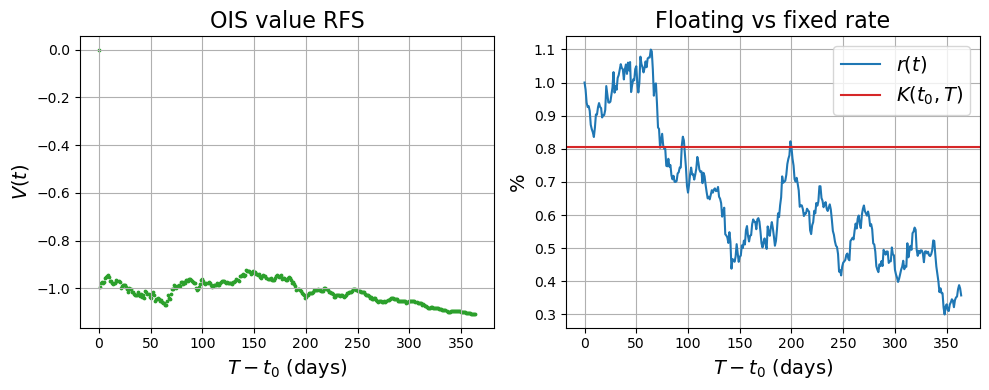

In [11]:
plt.figure(figsize=(10,4))

t_0 = 0
T = t_0 + 365
delta = +1 #RFS

plt.subplot(1,2,1)
for i in range(t_0, T):

    plt.scatter(i, get_mark_to_market_value(delta = delta, t_0 = t_0, t = i, T = T, process = process[0]), s=3, c='tab:green')
plt.title('OIS value RFS', fontsize=16)
plt.xlabel('$T-t_0$ (days)', fontsize=14)
plt.ylabel('$V(t)$', fontsize=14)
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(process[0][t_0:T], label='$r(t)$')
plt.axhline(get_ois_swap_rate(t_0=t_0, T=T, alpha=alpha, b=b, sigma=sigma, process=process[0]), c='tab:red', label='$K(t_0,T)$')
plt.xlabel('$T-t_0$ (days)', fontsize=14)
plt.legend(fontsize=14)
plt.ylabel('%', fontsize=14)
plt.title('Floating vs fixed rate', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

## Arrival times simulation

we define the intensity of our point process as:

$$ \lambda(t) = \exp{\left(\eta + \theta\cdot r(t) \right)} $$

so that we obtain something like:

In [12]:
eta = -1
theta = 1
lambda_t = np.exp(eta + theta*process[0])

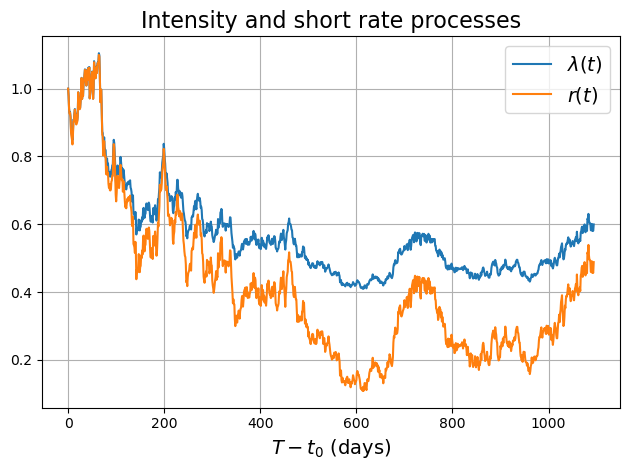

In [13]:
plt.plot(lambda_t, label='$\lambda(t)$')
plt.plot(process[0], label = '$r(t)$')
plt.legend(fontsize=14)
plt.title('Intensity and short rate processes', fontsize=16)
plt.xlabel('$T-t_{0}$ (days)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

We could use a results by Meyer that states that the counting process $N$ is a standard Poisson process under a change of time defined by A, relative to the time-changed filtration. Thus, for a sequence $ \{\xi_n\} $ of standard exponential random variables ($\xi_n \sim \exp(\lambda=1)$) that are i.i.d. the arrival time could be defined as:
$$ T_n \coloneqq \inf_{t}{\left\{\int_0^t {\lambda(s) ds} \geq \xi_1 + ...+ \xi_n\right\}}$$
So the recipy for our simulation is simply:
- draw $\xi_1 \sim \exp(\lambda=1)$
- record as $T_1$ the first time $t$ for which $\int_0^t{\lambda(s)ds}\geq \xi_1$
- draw $\xi_2 \sim \exp(\lambda=1)$
- record as $T_2$ the first time $t$ for which $\int_0^t{\lambda(s)ds}\geq \xi_1 + \xi_2$
- continue up to horizon T

Now let's consider the comulative process for $\lambda_t$ which we assume to be corresponding to $\int_0^t {\lambda(s)ds}$

In [14]:
xis = np.random.exponential(scale=100, size=2000)
cum_xis = np.cumsum(xis)

In [15]:
arrival_times = []
for n in range(1, 2000 + 1):
    T_n = np.argmax(cumulative_lambda >= cum_xis[n - 1])
    if T_n == 0:
        break
    else:
        arrival_times.append(T_n)

NameError: name 'cumulative_lambda' is not defined

In [ ]:
cumulative_lambda = np.cumsum(lambda_t)

plt.title('Cumulative process', fontsize=16)
for i in range(len(arrival_times)):
    plt.axvline(arrival_times[i], ls='--', c='red', lw=1)
plt.plot(cumulative_lambda, lw=2)
plt.xlabel('$T-t_{0}$ (days)', fontsize=14)
plt.ylabel('$\int_0^t {\lambda(s)ds}$', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
arrival_times

So for example a simulation of a link could follow the scheme:

In [ ]:
# Super partes simulation of the interest rate we take as SOFR:
TotPoints = 3 * 365

#simulation time grid
ts = np.linspace(0., 1., TotPoints)

#CIR process parameters
alpha = 5
b = 0.5
sigma = 1.
v_0 = 1

#Simulate CIR process
process = get_CIR(ts, alpha, b, sigma, v_0, n_samples=1)

In [ ]:
# Plot zero-bond and yield curve:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)

for i in range(1,365):
    plt.scatter(i, get_zero_bond_price(alpha, b, sigma, process=process[0], t=0, T= 0 + i),s=3, c='tab:blue')
plt.title('Zero-bond curve $T\mapsto p(t,T)$', fontsize=16)
plt.xlabel('$T-t$ (days)', fontsize=14)
plt.ylabel('$p(t,T)$', fontsize=14)
plt.grid(True)

plt.subplot(1,2,2)

for i in range(1,365):
    plt.scatter(i, get_ois_swap_rate(t_0=0, T=0+i, alpha=alpha, b=b, sigma=sigma, process= process[0]), s=3, c='tab:orange')
plt.title('OIS swap rate curve $T\mapsto R(t_0,T)$', fontsize=16)
plt.xlabel('$T-t_0$ (days)', fontsize=14)
plt.ylabel('$R(t_0,T)$', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.show()

Now for the single edge we simulate a cox process as intensity or rate for the arrival times of the contracts:

In [ ]:
eta = -1
theta = 1
lambda_t = np.exp(eta + theta*process[0])

plt.plot(lambda_t, label='$\lambda(t)$')
plt.plot(process[0], label = '$r(t)$')
plt.legend(fontsize=14)
plt.title('Intensity and short rate processes', fontsize=16)
plt.xlabel('$T-t_{0}$ (days)', fontsize=14)
plt.ylabel('%', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Let's draw the arrival times:
cumulative_lambda = np.cumsum(lambda_t)
xis = np.random.exponential(scale=100, size=2000)
cum_xis = np.cumsum(xis)

arrival_times = []
for n in range(1, 2000 + 1):
    T_n = np.argmax(cumulative_lambda >= cum_xis[n - 1])
    if T_n == 0:
        break
    else:
        arrival_times.append(T_n)

Now that we have the arrival times, let's build the contracts: for every contract I uniformly choose a maturity (expressed in days) $\in[1, 365]$, and then i randomly draw $\delta_{k}^{(ij)}=1\lor-1$

Keeping the discrete time framework we have that the discounted values for contracts are:
$$p(t,T)\coloneqq \mathbb{E}_{\mathbb{Q}}\left[ \left(\prod_{t_{i}=t}^{T}{1+r(t_{i})dt_{i}}\right)^{-1} \right]$$
$$V^{fixed}(t_0) = N\cdot\mathbb{E}_{\mathbb{Q}}\left[ \left(1+K(T-t_{0})\right) \cdot \left( \prod_{t_{i}=t_{0}}^{T}{1+r(t_{i})dt_{i}} \right)^{-1} \right] = N\cdot \left( 1 + K(T-t_{0})\right) p(t_0, T)$$
$$V^{floating}(t_0) = N\cdot\mathbb{E}_{\mathbb{Q}}\left[ \left( \prod_{t_{i}=t_{0}}^{T}{1+r(t_{i})dt_{i})} \right)\left( \prod_{t_{i}=t_{0}}^{T}{1+r(t_{i})dt_{i}} \right)^{-1}  \right] = N$$
So the OIS swap rate could be computed by making the initial value =0:
$$V(t_0) = 0 \iff K = \frac{1}{T- t_0}\frac{1-p(t_0, T)}{p(t_0, T)}$$
Likewise, the valuation at time $t$ is as follows:
$$V^{fixed}(t) = N\cdot\mathbb{E}_{\mathbb{Q}} \left[ (1+K\left(T-t_{0})\right)\cdot\left( \prod_{t_{i}=t}^{T}{1+r(t_{i})dt_{i}} \right)^{-1} \right] = N\left(1+R(t_{0},T)(T-t_{0})\right)p(t,T)$$
$$V^{floating}(t) = N\cdot\mathbb{E}_{\mathbb{Q}}\left[ \left( \prod_{t_{i}=t_{0}}^{T}{1+r(t_{i})dt_{i}} \right)\left( \prod_{t_{i}=t}^{T}{1+r(t_{i})dt_{i}} \right)^{-1} |\mathcal{F}_t\right] = N \cdot \left( \prod_{t_{i}=t_{0}}^{t}{1+r(t_{i})dt_{i}} \right)$$

Where we used the fact that the realization of $r(t)$ is $\mathcal{F}_t$-observable.
Therefore in total, using the definition of $R(t,T)$:
$$V(t) = N\delta\left[ \frac{1+R(t_0,T)(T-t_0)}{1+R(t,T)(T-t)} - \prod_{t_{i}=t_{0}}^{t}{1+r(t_{i})dt_{i}}  \right]$$

In [5]:
class simulation:
    """
    Handles the entire simulation
    """

    def __init__(self, alpha, b, sigma, v_0, years, seed = False, num_nodes = 10):
        """
        Sets coefficients and generates CIR process
        """
        
        self.alpha = alpha 
        self.b = b
        self.sigma = sigma
        self.v_0 = v_0
        self.TotPoints = years * 365

        #Default Cox-process coefficients:
        self.eta = -1
        self.theta = 1
        self.PriceMatrix = np.load('PriceMatrix.npy')

        #This is the reference interest rate we take for the entire simulation and all edges
        self.CIRProcess = get_CIR(
            np.linspace(0.,1., self.TotPoints),
            self.alpha,
            self.b,
            self.sigma,
            self.v_0,
            n_samples = 1,
            seed = seed,
        )[0]

        #We store a matrix of dictionaries to describe the edge features set
        self.num_nodes = num_nodes
        self.E = np.zeros((self.num_nodes, self.num_nodes), dtype=dict)

    def Price(self, t, T):

        return self.PriceMatrix[t, T - t]

    def MontecarloPrice(self, t, T, n_samples = 10000):
        """
        Performs Montecarlo simulation of CIR, generating 10 000 paths and then computes expectation out of it.
        """

        if t == T:

            return 1

        #Firstly we generate the paths
        paths = get_CIR(
            np.linspace( t  / self.TotPoints, T / self.TotPoints, T - t + 1),
            self.alpha,
            self.b,
            self.sigma,
            self.CIRProcess[t],
            n_samples = n_samples,
        )
        #Then for each path we compute the integral approximation using the prod
        prod = np.prod(1+(paths*1/365), axis=1)
        expectation = np.average(1/prod)
        return expectation

    def SwapRate(self, t_0, T):
        """
        Computes OIS swap rate, the fixed rate that makes the contract value 0 at the initial time
        """
        tau = (T - t_0) / 365
        #price = self.MontecarloPrice(t_0, T, n_samples=1000)
        price = self.Price(t_0, T)
        return (-1 / tau) * ( (price - 1) / price )

    def GetArrivalTimes(self):
        """
        Generates the Cox process and the arrival times
        """
        
        self.lambda_t = np.exp(self.eta + self.theta * self.CIRProcess)
        
        cumulative_lambda = np.cumsum(self.lambda_t)
        xis = np.random.exponential(scale=100, size=2000)
        cum_xis = np.cumsum(xis)

        arrival_times = []
        for n in range(1, 2000 + 1):
            T_n = np.argmax(cumulative_lambda >= cum_xis[n - 1])
            if T_n == 0:
                break
            else:
                arrival_times.append(T_n)
        return np.asarray(arrival_times)

    def GetFixedLeg(self, t_0, t, T, notional = 1):
        
        tau_0 = (T-t_0) / 365
        tau_t = (T-t) / 365
        return notional * ( (1 + self.SwapRate(t_0, T) * tau_0) / (1 + self.SwapRate(t,T)*tau_t)) 

    def GetFloatingLeg(self, t_0, t, notional = 1):

        accruing_process = self.CIRProcess[t_0: t]
        prod = np.prod(1 + accruing_process / 365)
        return prod * notional

    def MarkToMarketPrice(self, delta, t_0, t, T, notional = 1):
        """
        Computes the value at time t of an OIS that was traded at time t_0 with maturity T
        """

        if t < t_0:
            return 0
        if t >= T:
            return self.MarkToMarketPrice(delta, t_0, t-1, T)

        tau_0 = (T - t_0) / 365
        tau_t = (T - t) / 365

        accrued_process = self.CIRProcess[t_0: t]
        accrued_rate = np.prod(1+ accrued_process/365)

        return delta * notional * ( (1. + self.SwapRate(t_0, T) * tau_0) / (1. + self.SwapRate(t, T) * tau_t) - accrued_rate)

    def SimulateAllEdges(self):
        """
        By exploiting the inherent transaction symmetry, it is sufficient to cycle over the upper triangle of the edge
        feature matrix
        """
        loop = tqdm(range(self.num_nodes) )
        
        for i in loop:
            loop.set_postfix(Node=i)
            for j in range(i+1, self.num_nodes):
                self.SimulateEdge(i,j)
            
    def SimulateEdge(self,i,j):

        # Check i!=j as an institution cant trade with itself
        assert (i!=j)

        #FROM HERE ON WE MAY NEED TO ADD SYMMETRY ARGUMENTS FOR THE NETWORK TO PROPERLY WORK

        #Let's generate arrival times for (ij)
        arrival_times = self.GetArrivalTimes()
        
        #Let's generate maturities and deltas for every k-th transition
        maturities = np.random.randint(1, 365, size = len(arrival_times))
        deltas = np.random.choice ([-1,1], size = len(arrival_times))
        ending_times = np.minimum(arrival_times + maturities, self.TotPoints)

        self.E[i,j] = {
            'contracts':np.stack([arrival_times, deltas, ending_times], axis =1)
        }

        self.E[j,i] = {
            'contracts':np.stack([arrival_times, -1 * deltas, ending_times], axis = 1)
        }

    def GetEdgeValue(self,i,j):

        temp_cont = self.E[i,j]['contracts']
        value = np.zeros((self.TotPoints))

        for con in temp_cont:

            value += np.asarray([self.MarkToMarketPrice(delta = con[1], t_0 = con[0], t = t, T = con[2]) for t in range(0, self.TotPoints)])

        return value

    def GetEdgeBalance(self, i, j):
        temp_cont = self.E[i,j]['contracts']
        cashflows = np.zeros((self.TotPoints))

        for cont in temp_cont:
            cashflows[cont[2]:] += self.MarkToMarketPrice(delta = cont[1], t_0 = cont[0], t = cont[2], T = cont[2])

        return cashflows

    def GetNodeBalance(self, i):

        other_nodes = set(np.arange(self.num_nodes)) - set({i})
        cashflows = np.zeros((self.TotPoints))

        for j in other_nodes:
            cashflows+= self.GetEdgeBalance(i,j)
        return cashflows

    def GetContractMarginValue(self, contract):
        """
        This function returns the time series \in [0,self.TotPoints] representing the margin value of a specific contract
        """
        MarginValue = np.zeros((self.TotPoints))
        MarginValue += np.asarray([self.MarkToMarketPrice(delta = contract[1], t_0 = contract[0], t = t, T = contract[2]) - (1 + (self.CIRProcess[t] * 1 / 365) )*self.MarkToMarketPrice(delta = contract[1], t_0 = contract[0], t = t-1, T = contract[2]) for t in range(0, self.TotPoints)])

        return MarginValue

    def GetEdgeMarginValue(self, i,j):

        MarginValue = np.zeros((self.TotPoints))
        for cont in self.E[i,j]['contracts']:
            MarginValue += self.GetContractMarginValue(cont)
        return MarginValue

    def GetNodeMarginValue(self, i):

        MarginValue = np.zeros((self.TotPoints))
        other_nodes = set(np.arange(self.num_nodes)) - set({i})
        for j in other_nodes:
            MarginValue += self.GetEdgeMarginValue(i,j)
        return MarginValue
    
    def GetNodeValue(self, node):
        
        value = np.zeros((self.TotPoints))
        for i in range(0,self.num_nodes):
            if i == node:
                pass
            else:
                value += self.GetEdgeValue(node, i)
        return value

Transaction symmetry could be expressed as follows.

Let $i$,$j$ be two nodes of our financial network, then considering the $k$-th transaction we get:
$$\delta_k(i,j) = -\delta_k(j,i)$$
$$ t_{k}(i,j) = t_{k}(j,i) $$
$$T_{k}(i,j) = T_k(j,i) $$

In [ ]:
sim = simulation(alpha, b, sigma, v_0, years)

plt.plot([sim.MontecarloPrice(0,i, n_samples = 100000) for i in range(0,365)], label='n_samples = 100000')
plt.plot([sim.MontecarloPrice(0,i) for i in range(0,365)], label='n_samples = 10000')
plt.plot([sim.MontecarloPrice(0,i, n_samples = 1000) for i in range(0,365)], label='n_samples = 1000')
plt.plot([sim.MontecarloPrice(0,i, n_samples = 100) for i in range(0,365)], label='n_samples = 100')
plt.plot([sim.MontecarloPrice(0,i, n_samples = 10) for i in range(0,365)], label='n_samples = 10')

plt.ylabel('$p(t,T)$', fontsize=14)
plt.xlabel('$T-t$', fontsize=14)
plt.title('$T\mapsto p(t,T)$ Montecarlo simulation', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()

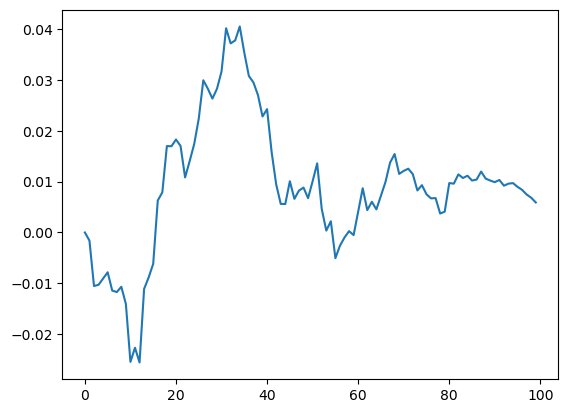

In [127]:
plt.plot([sim.MarkToMarketPrice(+1, 0, i, 100) for i in range(0,100)])

In [6]:
alpha = 5
b = 0.5
sigma = 1.
v_0 = 1
years = 3
sim = simulation(alpha, b, sigma, v_0, years, seed = True, num_nodes = 1000)
sim.SimulateAllEdges()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
np.save('edge_features.npy', sim.E)

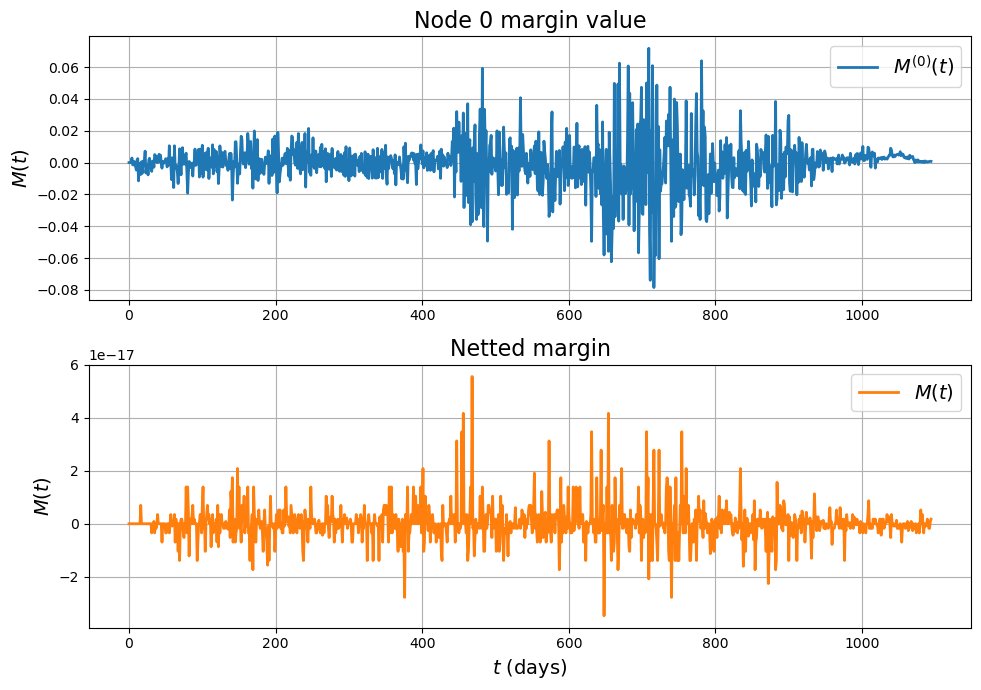

In [316]:
plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.plot(sim.GetNodeMarginValue(0), lw=2, label='$M^{(0)}(t)$')

plt.ylabel('$M(t)$', fontsize=14)
plt.title('Node 0 margin value', fontsize=16)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(2,1,2)
netted_margin = np.zeros((sim.TotPoints))
for i in range(sim.num_nodes):
    netted_margin += sim.GetNodeMarginValue(i)

plt.plot(netted_margin, lw=2, c='tab:orange', label='$M(t)$')

plt.xlabel('$t$ (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)
plt.title('Netted margin', fontsize=16)
plt.legend(fontsize=14)
plt.grid()

plt.tight_layout()
plt.savefig('Node0margin.pdf')
plt.show()

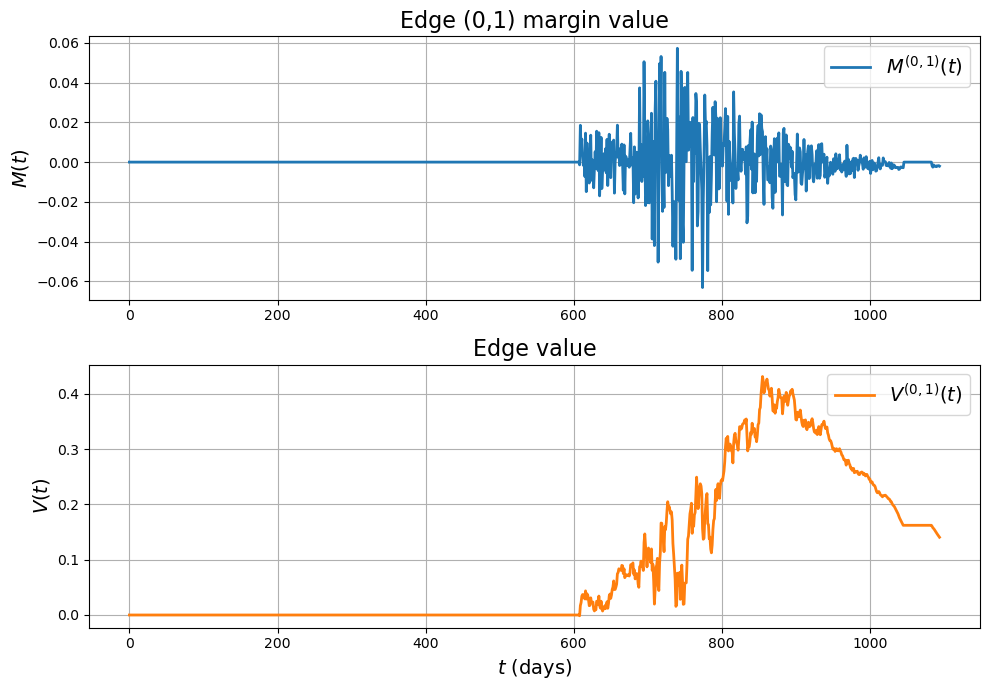

In [308]:
plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.plot(sim.GetEdgeMarginValue(0,1), lw=2, label='$M^{(0,1)}(t)$')

plt.ylabel('$M(t)$', fontsize=14)
plt.title('Edge (0,1) margin value', fontsize=16)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(2,1,2)
plt.plot(sim.GetEdgeValue(0,1), lw=2, c='tab:orange', label='$V^{(0,1)}(t)$')

plt.xlabel('$t$ (days)', fontsize=14)
plt.ylabel('$V(t)$', fontsize=14)
plt.title('Edge value', fontsize=16)
plt.legend(fontsize=14)
plt.grid()

plt.tight_layout()
plt.savefig('Edge01margin.pdf')
plt.show()

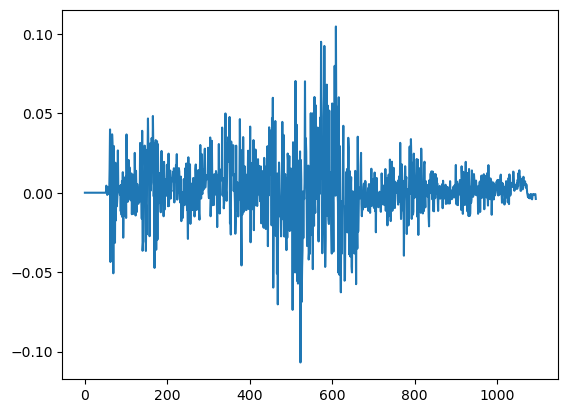

In [262]:
plt.plot(sim.GetNodeMarginValue(0))

In [273]:
margins = []
for i in range(sim.num_nodes):
    margins.append(sim.GetNodeMarginValue(i))

In [275]:
margins = np.asarray(margins)

In [278]:
margins.flatten()

array([0.        , 0.        , 0.        , ..., 0.00156363, 0.001428  ,
       0.00165952])

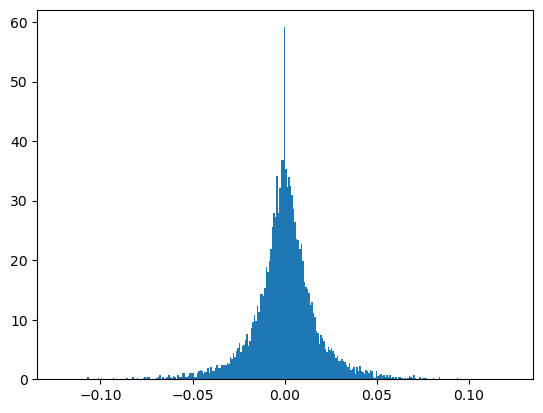

In [281]:
plt.hist(margins.flatten(), bins=300, density=True)
plt.show()

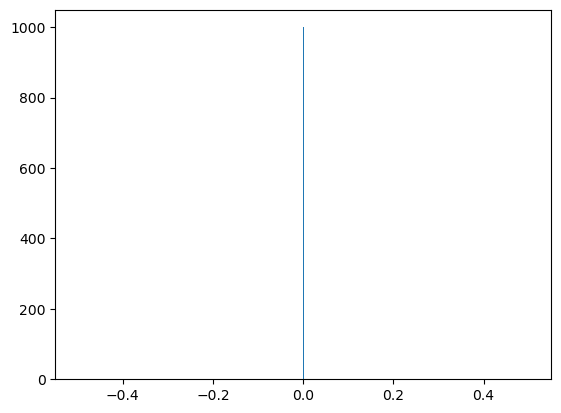

In [269]:
plt.hist(margins, bins=1000, density=True)
plt.show()

(array([  4.,   8.,  40., 909.,  79.,  33.,  19.,   2.,   0.,   1.]),
 array([-0.0259643 , -0.01919172, -0.01241914, -0.00564657,  0.00112601,
         0.00789859,  0.01467117,  0.02144375,  0.02821633,  0.03498891,
         0.04176149]),
 <BarContainer object of 10 artists>)

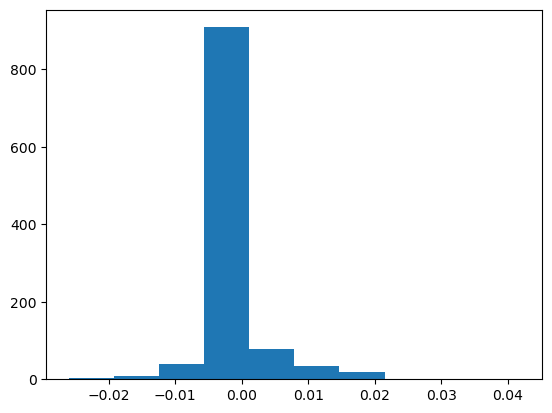

In [252]:
v_t1 = np.asarray([sim.MarkToMarketPrice(delta = contract[1], t_0 = contract[0], t = t, T = contract[2]) for t in range(0, sim.TotPoints)])
v_t0 = np.asarray([sim.MarkToMarketPrice(delta = contract[1], t_0 = contract[0], t = t-1, T = contract[2]) for t in range(0, sim.TotPoints)])

#plt.plot(v_t1)
#plt.plot(v_t0)
plt.hist(v_t1-v_t0)

In [243]:
sim.GetContractMarginValue(sim.E[0,1]['contracts'][0])

ValueError: operands could not be broadcast together with shapes (1095,) (1094,) (1095,) 

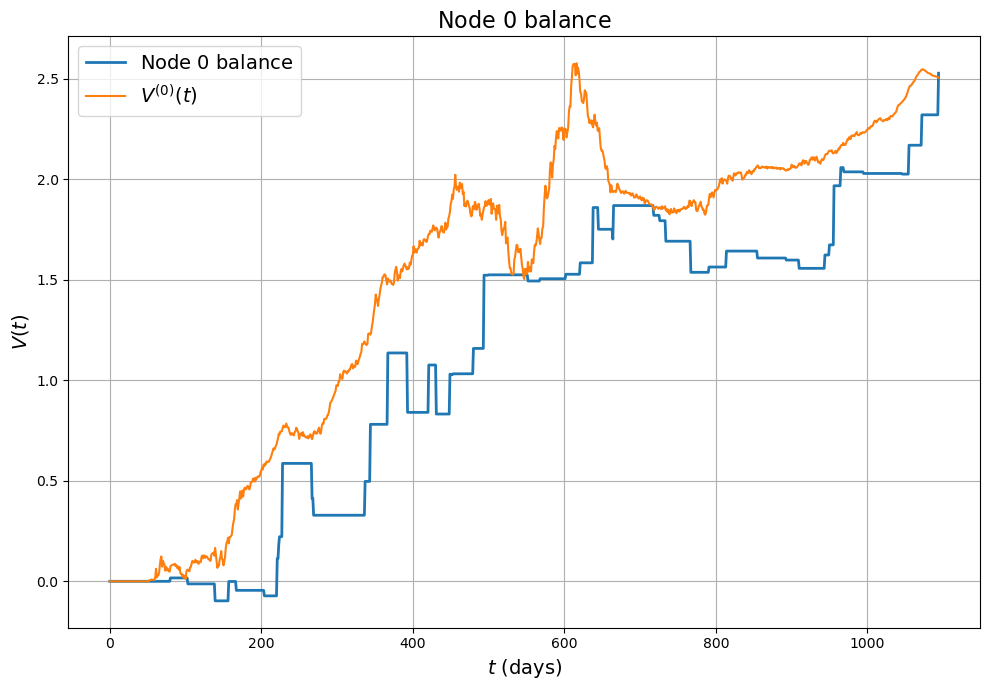

In [303]:
plt.figure(figsize=(10,7))
for i in range(0,1):
    plt.plot(sim.GetNodeBalance(i), lw=2, label=f'Node ${i}$ balance')
    plt.plot(sim.GetNodeValue(i), label='$V^{(0)}(t)$')
    #for j in (set(np.arange(sim.num_nodes))-set({i})):
     #   plt.plot(sim.GetEdgeCashFlow(i,j), ls='--', label=f'$({i},{j})$')

plt.xlabel('$t$ (days)', fontsize=14)
plt.ylabel('$V(t)$', fontsize=14)
plt.title('Node $0$ balance', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig('Node0Balance.pdf')
plt.show()

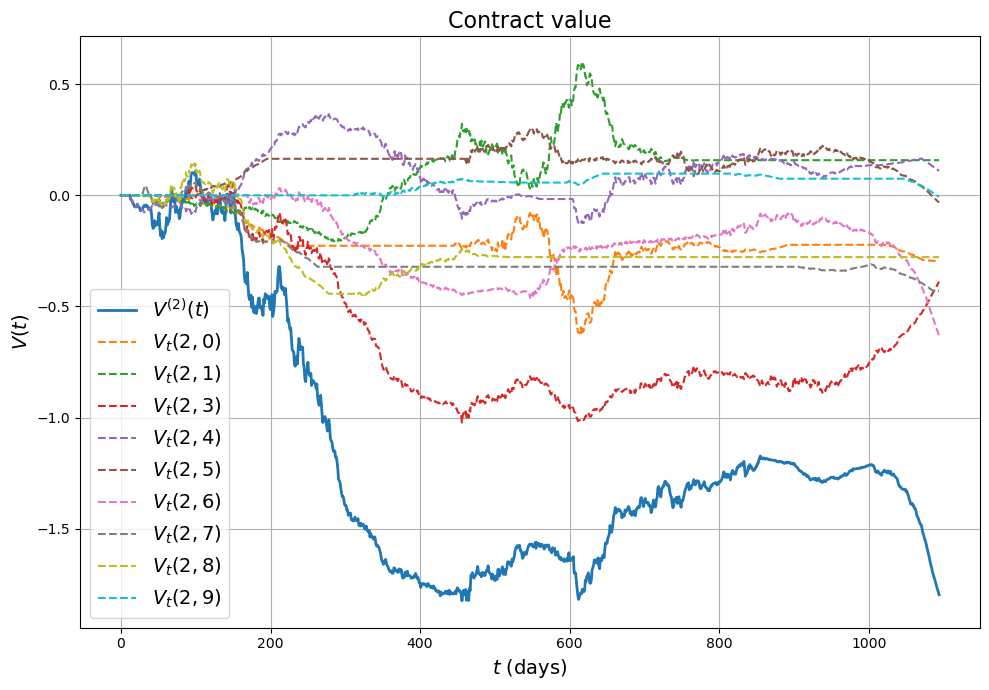

In [297]:
plt.figure(figsize=(10,7))
for i in range(2,3):
    plt.plot(sim.GetNodeValue(i), lw=2, label='$V^{(2)}(t)$')
    for j in (set(np.arange(sim.num_nodes))-set({i})):
        plt.plot(sim.GetEdgeValue(i,j), ls='--', label=f'$V_t({i},{j})$')

plt.xlabel('$t$ (days)', fontsize=14)
plt.ylabel('$V(t)$', fontsize=14)
plt.title('Contract value', fontsize=16)
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.savefig('Node1_contract_values.pdf')
plt.show()

In [298]:
sim.E[2,0]['contracts']

array([[  51,    1,   80],
       [  90,    1,  228],
       [ 444,   -1,  500],
       [ 450,    1,  664],
       [ 491,    1,  726],
       [ 555,    1,  814],
       [ 764,   -1,  893],
       [1021,    1, 1095],
       [1072,   -1, 1095]])

In [233]:
sim.E[0,5]

{'contracts': array([[   9,    1,   39],
        [ 167,   -1,  452],
        [ 233,    1,  235],
        [ 672,   -1,  692],
        [ 683,    1,  957],
        [ 742,    1, 1095],
        [ 793,   -1,  959],
        [ 996,   -1, 1079]])}

In [34]:
alpha = 5
b = 0.5
sigma = 1.
v_0 = 1
years = 3

sim = simulation(alpha, b, sigma, v_0, years)
#sim.PlotCIRProcess()
#sim.PlotPrice()
#sim.PlotSwapRate()

sim.SimulateAllEdges()
#sim.SimulateEdge(0,1)

In [311]:
sim.E[0,1]

{'contracts': array([[ 607,   -1,  767],
        [ 622,    1,  956],
        [ 675,    1,  791],
        [ 686,    1, 1046],
        [1083,    1, 1095]])}

In [318]:
sim.E[0,1]

{'contracts': array([[ 100,   -1,  163],
        [ 218,   -1,  571],
        [ 224,    1,  422],
        [ 331,    1,  380],
        [ 538,    1,  676],
        [ 558,    1,  599],
        [ 671,   -1,  924],
        [ 916,    1, 1095]])}